### ДЗ 3. Продвинутые сверточные архитектуры. Transfer Learning

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorboard
import tensorflow_datasets as tfds
import os

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [10]:
(ds_train, ds_test), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

KeyboardInterrupt: 

In [2]:
# Не знаю в чем тут дело - не получилось никаким способом выкачать датасет из tfds... 
# Раз 5 пробовал - закачка останавливается процентах на 7-10 и висит бесконечно.. 
# В итоге просто скачал его файлом из Кэггла..
# Правда теперь придется самому загружать картинки в виде датасета

In [3]:
import pathlib
import PIL.Image as Image

In [4]:
data_dir = pathlib.Path('dataset/images/')

In [5]:
# Сколько их там...
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

101000

In [6]:
# Посмотрим что нибудь
donuts = list(data_dir.glob('donuts/*'))
donuts[0]

PosixPath('dataset/images/donuts/3008531.jpg')

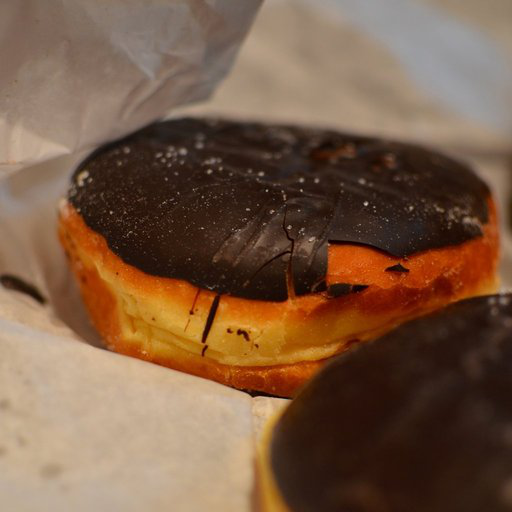

In [7]:
Image.open(donuts[0])

In [8]:
Image.open(donuts[0]).size

(512, 512)

In [9]:
BATCH_SIZE = 32
IMAGE_SIZE = 196

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 101000 files belonging to 101 classes.
Using 80800 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 101000 files belonging to 101 classes.
Using 20200 files for validation.


In [12]:
# Наши классы
class_names = train_ds.class_names
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

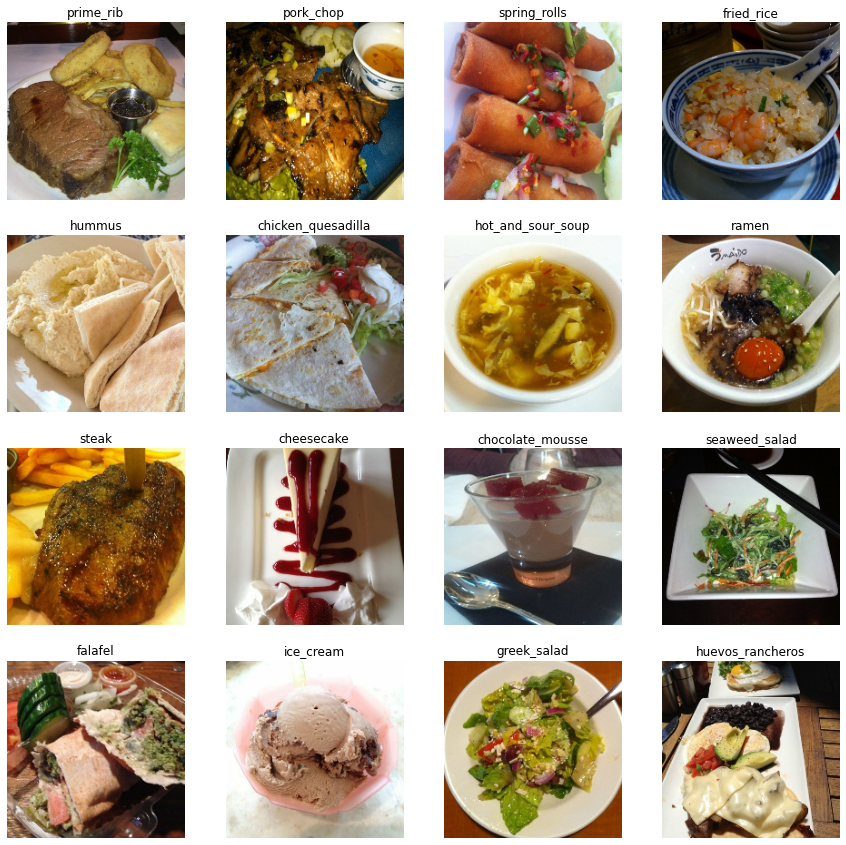

In [13]:
# Немного примеров
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
# Оптимизация кеширования
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
# Аугментация
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

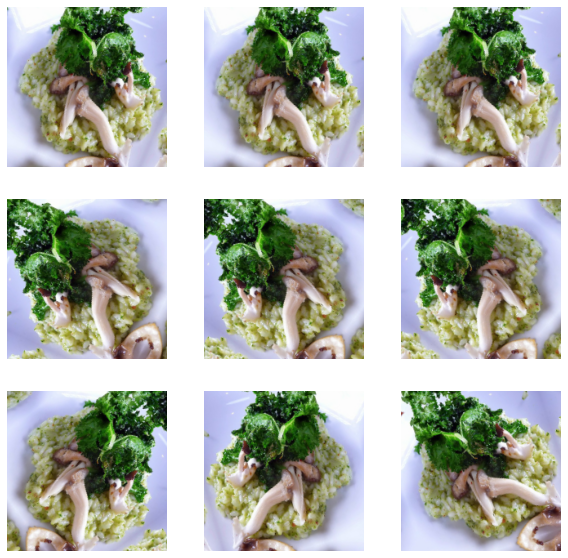

In [16]:
# Тест того, как работает аугментация
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [17]:
# Претрейненная сеть (сначала с залоченными весами)
base_net = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

base_net.trainable = False

In [18]:
# Freeze BatchNormLayers
# for layer in base_net.layers:
#     if 'batch_normalization' in layer.name:
#         layer.trainable = False

In [19]:
base_net.layers[2].trainable

False

In [20]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [21]:
# test_batch = iter(val_ds).next()
# img = test_batch[0].numpy()[0]

In [22]:
# img.shape

In [23]:
# rescale(img[None, ...]).shape

In [24]:
# def prepare(img, label):
#    return tf.cast(img, tf.float32)/127. - 1., label

In [25]:
# train_ds = train_ds.map(prepare)

In [26]:
# val_ds = val_ds.map(prepare)

In [27]:
# Теперь соберем модель
def build_model(input_size = (IMAGE_SIZE, IMAGE_SIZE, 3), training=True):
    inputs = tf.keras.Input(shape=input_size)
    x = data_augmentation(inputs)
    x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
    # x = rescale(x)
    x = base_net(x, training=training)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    outputs = tf.keras.layers.Dense(101, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
model = build_model(training=False)

In [74]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 196, 196, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 196, 196, 3)       0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 196, 196, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 196, 196, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1536)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1536)              0   

In [75]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [76]:
# Попробуем!
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5
2525/2525 [==============================] - 311s 119ms/step - loss: 3.2812 - accuracy: 0.2429 - val_loss: 2.1899 - val_accuracy: 0.4515
Epoch 2/5
2525/2525 [==============================] - 303s 120ms/step - loss: 2.3879 - accuracy: 0.4068 - val_loss: 2.0376 - val_accuracy: 0.4866
Epoch 3/5
2525/2525 [==============================] - 302s 119ms/step - loss: 2.2399 - accuracy: 0.4381 - val_loss: 1.9758 - val_accuracy: 0.4969
Epoch 4/5
2525/2525 [==============================] - 285s 113ms/step - loss: 2.1605 - accuracy: 0.4571 - val_loss: 1.9443 - val_accuracy: 0.5062
Epoch 5/5
2525/2525 [==============================] - 280s 111ms/step - loss: 2.0961 - accuracy: 0.4667 - val_loss: 1.8980 - val_accuracy: 0.5151


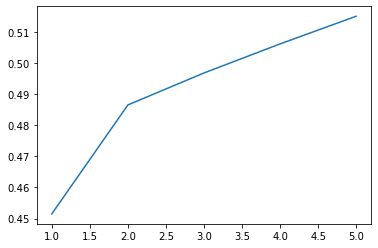

In [79]:
plt.plot(range(1, 6), history.history['val_accuracy'])

In [80]:
# Кажется, что надо попробовать разморозить веса Инсепшна и по-тюнить всё вместе..

In [81]:
base_net.trainable=True

In [82]:
# Freeze BatchNormLayers
for layer in base_net.layers:
    if 'batch_normalization' in layer.name:
        layer.trainable = False

In [85]:
global_average = model.layers[5]
dense1 = model.layers[7]
dense2 = model.layers[8]

In [88]:
# Пересоберём
inputs = tf.keras.Input(shape=(196, 196, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
x = base_net(x, training=True)
x = global_average(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = dense1(x)
outputs = dense2(x)
model_fine_tune = tf.keras.Model(inputs, outputs)

In [89]:
model_fine_tune.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 196, 196, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 196, 196, 3)       0         
_________________________________________________________________
tf.math.truediv_6 (TFOpLambd (None, 196, 196, 3)       0         
_________________________________________________________________
tf.math.subtract_6 (TFOpLamb (None, 196, 196, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1536)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1536)              0   

In [90]:
base_learning_rate = 0.0001
model_fine_tune.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [91]:
model_fine_tune.fit(train_ds,
                    epochs=1,
                    validation_data=val_ds)

2525/2525 [==============================] - 803s 312ms/step - loss: 1.8505 - accuracy: 0.5295 - val_loss: 1.2811 - val_accuracy: 0.6596


In [92]:
# Заметно лучше выглядит

In [29]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    period=1,
    save_weights_only=True)

In [94]:
model_fine_tune.fit(train_ds,
                    epochs=2,
                    validation_data=val_ds,
                   callbacks=[checkpoint_callback])

Epoch 1/2
2525/2525 [==============================] - 706s 279ms/step - loss: 1.1692 - accuracy: 0.6867 - val_loss: 1.1588 - val_accuracy: 0.6959
Epoch 2/2
2525/2525 [==============================] - 780s 309ms/step - loss: 0.9807 - accuracy: 0.7334 - val_loss: 1.1062 - val_accuracy: 0.7082


In [33]:
# Продолжаем по плану
model = build_model()
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# model.build(tf.TensorShape([1, None]))

In [34]:
model.fit(train_ds,
                    epochs=2,
                    validation_data=val_ds,
                   callbacks=[checkpoint_callback])

Epoch 1/2
2525/2525 [==============================] - 313s 119ms/step - loss: 0.8040 - accuracy: 0.7782 - val_loss: 0.9920 - val_accuracy: 0.7414
Epoch 2/2
2525/2525 [==============================] - 278s 110ms/step - loss: 0.7501 - accuracy: 0.7925 - val_loss: 0.9771 - val_accuracy: 0.7459


In [35]:
# Так получилось, что это был прогон с залоченными весами инсепшна. 
# Только классификатор тренировался.. 

In [48]:
base_net = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

base_net.trainable = False

In [37]:
# Freeze BatchNormLayers
for layer in base_net.layers:
    if 'batch_normalization' in layer.name:
        layer.trainable = False

In [49]:
model = build_model(training=False)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [46]:
base_net.trainable=False

In [50]:
model.fit(train_ds,
                    epochs=2,
                    validation_data=val_ds,
                   callbacks=[checkpoint_callback])

Epoch 1/2
2525/2525 [==============================] - 317s 121ms/step - loss: 0.7232 - accuracy: 0.7981 - val_loss: 0.9789 - val_accuracy: 0.7457
Epoch 2/2
2525/2525 [==============================] - 300s 119ms/step - loss: 0.7058 - accuracy: 0.8039 - val_loss: 0.9732 - val_accuracy: 0.7484


In [84]:
base_net = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

base_net.trainable = False

In [85]:
# Freeze BatchNormLayers
for layer in base_net.layers:
    if 'batch_normalization' in layer.name:
        layer.trainable = False

In [86]:
model = build_model(training=False)

In [87]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [88]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_2'

In [89]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [90]:
model.fit(train_ds,
                    epochs=2,
                    validation_data=val_ds,
                   callbacks=[checkpoint_callback])

Epoch 1/2
2525/2525 [==============================] - 318s 122ms/step - loss: 0.6850 - accuracy: 0.8082 - val_loss: 0.9814 - val_accuracy: 0.7481
Epoch 2/2
2525/2525 [==============================] - 305s 121ms/step - loss: 0.6750 - accuracy: 0.8113 - val_loss: 0.9713 - val_accuracy: 0.7518


In [92]:
# Что-то никак не получается запустить тренировку всей сети... 
# Падают метрики, как будто сеть инсепшн не помнит весов
# Попробуем сделать это как делали до этого. Пересоберем готовую сеть с разлоченными весами
# Без загрузки весов с диска

In [93]:
base_net.trainable=True
# Freeze BatchNormLayers
for layer in base_net.layers:
    if 'batch_normalization' in layer.name:
        layer.trainable = False

global_average = model.layers[5]
dense1 = model.layers[7]
dense2 = model.layers[8]

In [97]:
# Пересоберём
inputs = tf.keras.Input(shape=(196, 196, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
x = base_net(x, training=True)
x = global_average(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = dense1(x)
outputs = dense2(x)
model_fine_tune = tf.keras.Model(inputs, outputs)

In [98]:
model_fine_tune.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 196, 196, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 196, 196, 3)       0         
_________________________________________________________________
tf.math.truediv_10 (TFOpLamb (None, 196, 196, 3)       0         
_________________________________________________________________
tf.math.subtract_10 (TFOpLam (None, 196, 196, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1536)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 1536)              0  

In [99]:
base_learning_rate = 0.0001
model_fine_tune.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [100]:
model_fine_tune.fit(train_ds,
                    epochs=2,
                    validation_data=val_ds,
                   callbacks=[checkpoint_callback])

Epoch 1/2
2525/2525 [==============================] - 785s 304ms/step - loss: 0.8324 - accuracy: 0.7704 - val_loss: 1.0711 - val_accuracy: 0.7186
Epoch 2/2
2525/2525 [==============================] - 768s 304ms/step - loss: 0.7369 - accuracy: 0.7899 - val_loss: 1.1026 - val_accuracy: 0.7181


In [101]:
# Что-то не идет обучение дальше...

In [102]:
base_net = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

base_net.trainable = False

In [103]:
model = build_model(training=False)

In [104]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [105]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [107]:
model.fit(train_ds,
                    epochs=2,
                    validation_data=val_ds,
                   callbacks=[checkpoint_callback])

Epoch 1/2
2525/2525 [==============================] - 316s 121ms/step - loss: 0.6156 - accuracy: 0.8257 - val_loss: 1.0191 - val_accuracy: 0.7499
Epoch 2/2
2525/2525 [==============================] - 304s 120ms/step - loss: 0.5590 - accuracy: 0.8405 - val_loss: 1.0117 - val_accuracy: 0.7525


In [163]:
# Долговато до-учивать такую большую сеть на 101 тысяче картинок :))
# Ну - какая-то точность получилась - 75% - прогоним тест-инференс

### Критически важное действие (как оказалось) - на инференс вырубить вручную trainable на всех слоях.. иначе продолжает трениться похоже - и все время меняются результаты, в зависимости от количества примеров в батче. Либо - использовать predict

In [108]:
for layer in model.layers:
    layer.trainable = False

In [109]:
test_batch = iter(val_ds).next()

In [110]:
predicts = np.argmax(model(test_batch[0], training=False), axis=1)

In [111]:
predicts

array([83, 56,  7, 55,  3, 42, 13, 81, 60, 74, 68, 12, 58, 59, 96, 28, 20,
       38, 32, 71, 50, 60, 81, 66, 42, 93, 51, 52, 29, 49, 33, 86])

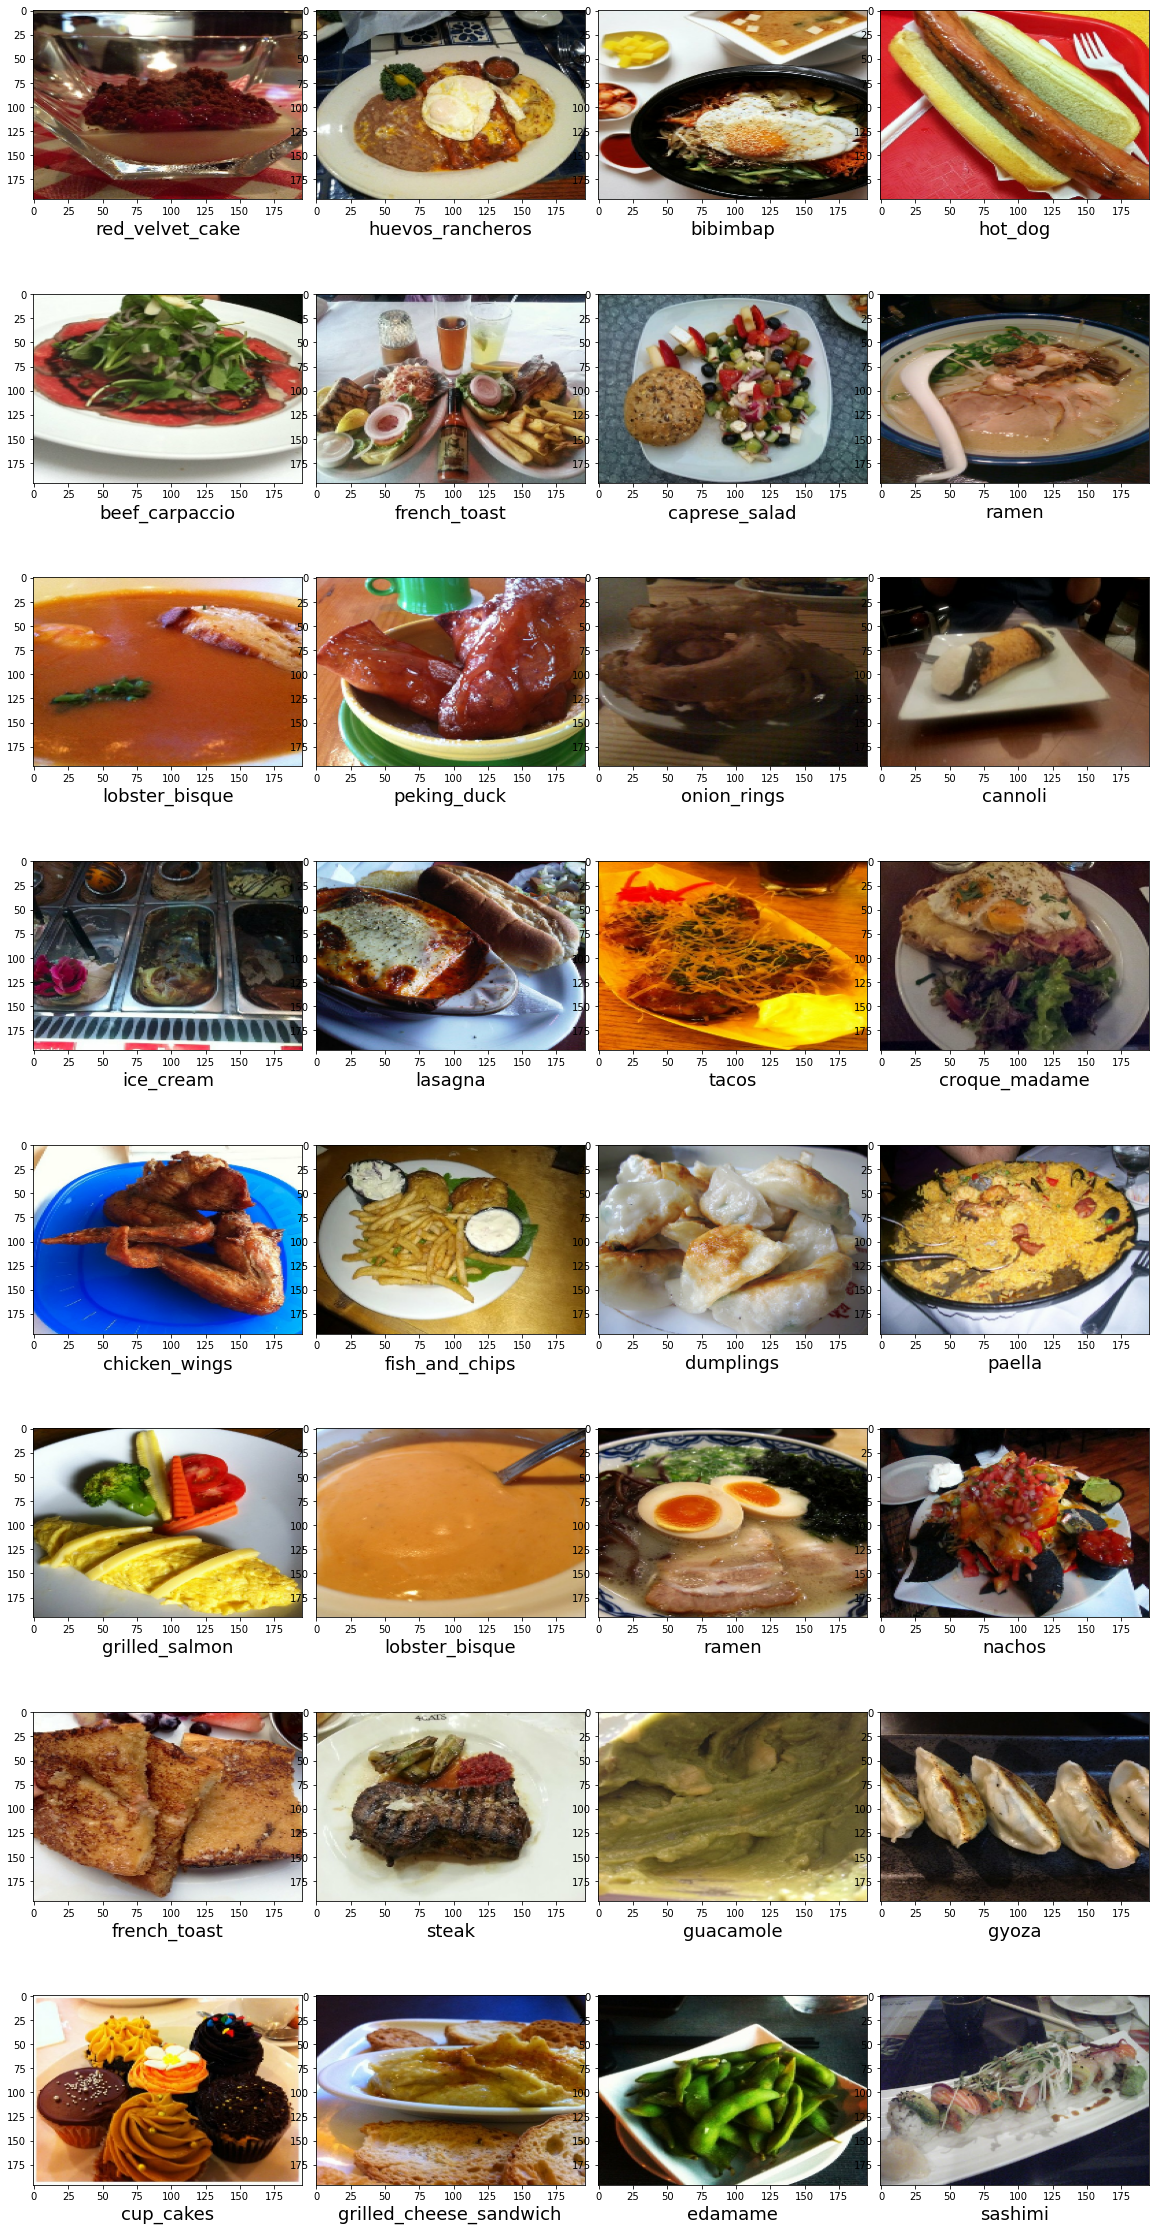

In [120]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20,40))
for idx, image in enumerate(test_batch[0]):
    row = idx // 4
    col = idx % 4
    axes[row, col].imshow(np.array(image).astype(int), cmap="gray", aspect="auto")
    axes[row, col].set_xlabel(class_names[predicts[idx]], fontsize=18)
plt.subplots_adjust(wspace=.05, hspace=.5)
plt.show()

In [121]:
# Что-то определяет. Еще бы самому знать все эти названия ))

### Вот тут у меня возник вопрос... Если я меняю количество картинок в батче, подаваемых на инференс - у меня меняются предсказания. Как это возможно? И как это исправить?

In [122]:
# Беру 3 картинки в батче.
predicts = np.argmax(model(test_batch[0][:3], training=False), axis=1)
predicts

array([83, 56,  7])

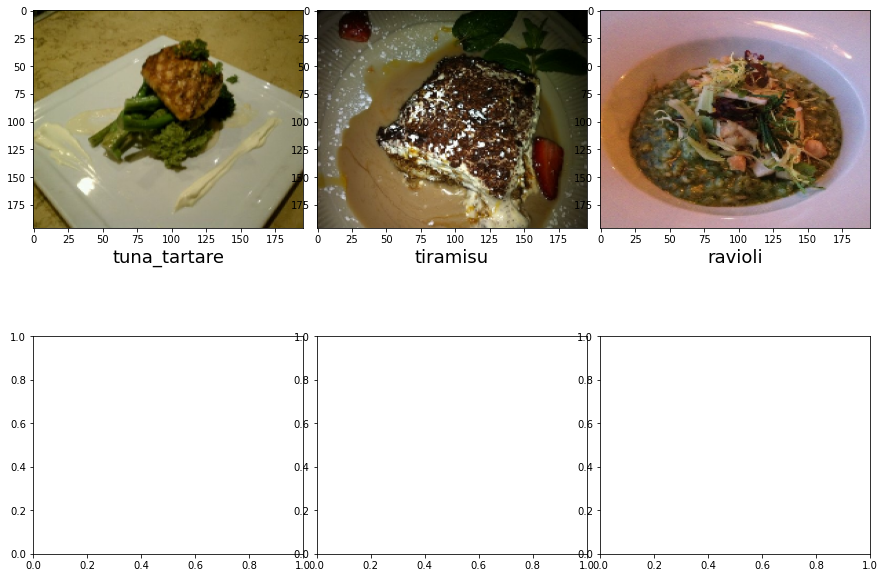

In [104]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for idx, image in enumerate(test_batch[0][:3]):
    row = idx // 4
    col = idx % 4
    axes[row, col].imshow(image/255, cmap="gray", aspect="auto")
    axes[row, col].set_xlabel(class_names[predicts[idx]], fontsize=18)
plt.subplots_adjust(wspace=.05, hspace=.5)
plt.show()

In [123]:
# Беру 2 картинки в батче.
predicts = np.argmax(model(test_batch[0][:2], training=False), axis=1)
predicts

array([83, 56])

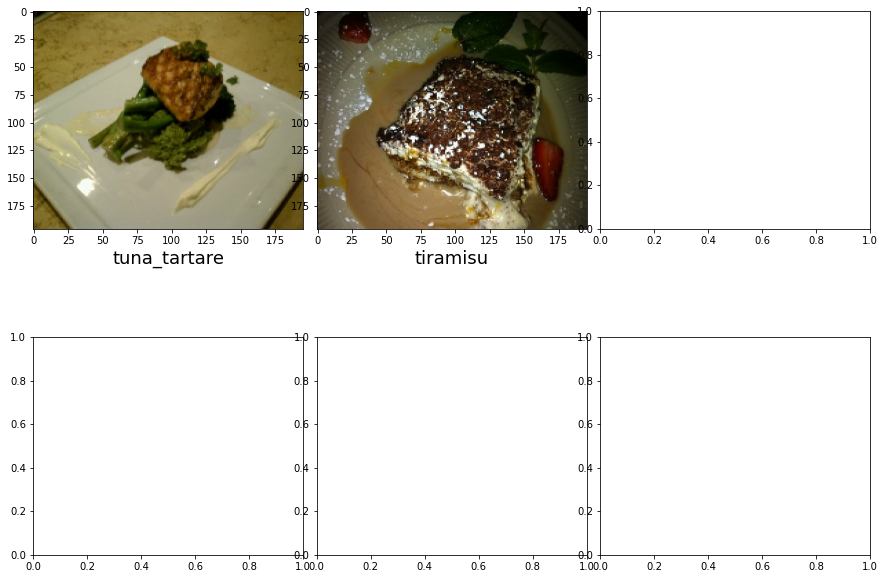

In [106]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for idx, image in enumerate(test_batch[0][:2]):
    row = idx // 4
    col = idx % 4
    axes[row, col].imshow(image/255, cmap="gray", aspect="auto")
    axes[row, col].set_xlabel(class_names[predicts[idx]], fontsize=18)
plt.subplots_adjust(wspace=.05, hspace=.5)
plt.show()

In [124]:
# Беру 1 картинку.
predicts = np.argmax(model(test_batch[0][:1], training=False), axis=1)
predicts

array([83])

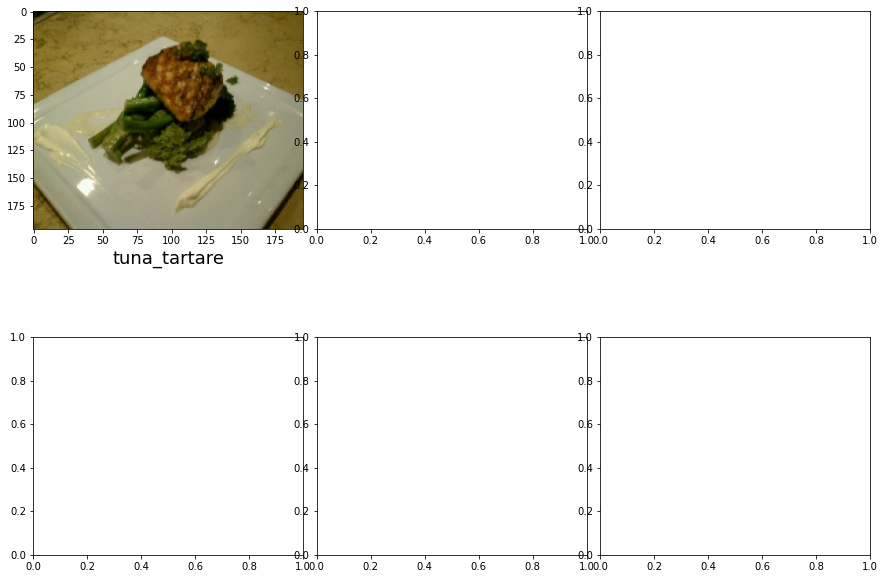

In [108]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for idx, image in enumerate(test_batch[0][:1]):
    row = idx // 4
    col = idx % 4
    axes[row, col].imshow(image/255, cmap="gray", aspect="auto")
    axes[row, col].set_xlabel(class_names[predicts[idx]], fontsize=18)
plt.subplots_adjust(wspace=.05, hspace=.5)
plt.show()

In [125]:
predicts = np.argmax(model(test_batch[0][:3], training=False), axis=1)
predicts

array([83, 56,  7])

In [126]:
predicts = np.argmax(model(test_batch[0][:4], training=False), axis=1)
predicts

array([83, 56,  7, 55])

In [127]:
predicts = np.argmax(model(test_batch[0][:5], training=False), axis=1)
predicts

array([83, 56,  7, 55,  3])

In [128]:
predicts = np.argmax(model(test_batch[0][:6], training=False), axis=1)
predicts

array([83, 56,  7, 55,  3, 42])

In [129]:
predicts = np.argmax(model(test_batch[0][:7], training=False), axis=1)
predicts

array([83, 56,  7, 55,  3, 42, 13])

In [133]:
# Вобщем все разрешилось фризом весов модели перед инференсом

In [130]:
predicts = np.argmax(model(test_batch[0][:1], training=False), axis=1)
predicts

array([83])

In [131]:
predicts = np.argmax(model(test_batch[0][1:2], training=False), axis=1)
predicts

array([56])

In [132]:
predicts = np.argmax(model(test_batch[0][2:3], training=False), axis=1)
predicts

array([7])

In [134]:
img = Image.open('dataset/how-to-make-donuts-20.jpg')

In [135]:
image = img.resize((196, 196), Image.ANTIALIAS)

In [136]:
# prepare(np.array(image, np.float32), 0)

In [137]:
predicts = np.argmax(model(np.array(image, np.float32)[None, ...], training=False), axis=1)
predicts

array([31])

In [138]:
class_names[31]

'donuts'

In [139]:
img1 = Image.open('dataset/637e34d0-fb3d-478d-9119-7657008ed4e4.jpg')

In [140]:
image1 = img.resize((196, 196), Image.ANTIALIAS)

In [141]:
predicts = np.argmax(model(np.array(image1, np.float32)[None, ...], training=False), axis=1)
predicts

array([31])

In [142]:
class_names[31]

'donuts'

In [143]:
batch = tf.stack((np.array(image, np.float32), np.array(image1, np.float32)))

In [144]:
batch.shape

TensorShape([2, 196, 196, 3])

In [145]:
predicts = np.argmax(model(batch, training=False), axis=1)
predicts

array([31, 31])

In [146]:
class_names[31]

'donuts'

### Попробуем теперь не тюнить исходные веса

In [44]:
# Претрейненная сеть
base_net_locked = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)
base_net_locked.trainable = False

In [45]:
def prepare(img, label):
    return tf.cast(img, tf.float32)/127. - 1., label

In [46]:
train_ds_scaled = train_ds.map(prepare)

In [47]:
model_locked = tf.keras.Sequential([
     base_net_locked,
     tf.keras.layers.GlobalAveragePooling2D(),
     tf.keras.layers.Dense(101, activation='softmax')
])

In [48]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

model_locked.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [49]:
model_locked.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1536)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 101)               155237    
Total params: 54,491,973
Trainable params: 155,237
Non-trainable params: 54,336,736
_________________________________________________________________


In [50]:
val_ds_scaled = val_ds.map(prepare)

In [51]:
history = model_locked.fit(
    train_ds_scaled,
    epochs=2,
    validation_data=val_ds_scaled)

Epoch 1/2
 421/2525 [====>.........................] - ETA: 3:16 - loss: 4.5222 - accuracy: 0.0667

KeyboardInterrupt: 

In [364]:
# Гораздо слабее скор на мороженной модели

In [433]:
test_batch = iter(val_ds).next()

In [434]:
img = test_batch[0][0]
predicts = np.argmax(model_locked(img[None, ...], training=False), axis=1)
predicts

array([13])

In [435]:
predicts = np.argmax(model_locked(test_batch[0], training=False), axis=1)
predicts

array([ 13,  46,  47,  60,  51,  24,  55,  34,  50,  85,  41,  51,  39,
         1,  51,  39, 100,  20,  36,  65,  81,  77,  32,  75,  42,  13,
        37,  24,  14,  67, 100,  64])

In [436]:
img = test_batch[0][5]
predicts = np.argmax(model_locked(img[None, ...], training=False), axis=1)
predicts

array([24])

In [437]:
img = test_batch[0][6]
predicts = np.argmax(model_locked(img[None, ...], training=False), axis=1)
predicts

array([55])

In [412]:
# Здесь - нормально все... вобщем нужны еще эксперименты

In [413]:
# Попробуем MobileNet
base_net_locked = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)
base_net_locked.trainable = False

9412608/9406464 [==============================] - 4s 0us/step


In [414]:
model_locked = tf.keras.Sequential([
     base_net_locked,
     tf.keras.layers.GlobalAveragePooling2D(),
     tf.keras.layers.Dense(101, activation='softmax')
])

In [415]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

model_locked.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [416]:
history = model_locked.fit(
    train_ds,
    epochs=2,
    validation_data=val_ds)

Epoch 1/2
2525/2525 [==============================] - 302s 118ms/step - loss: 3.6019 - accuracy: 0.2084 - val_loss: 2.1938 - val_accuracy: 0.4675
Epoch 2/2
2525/2525 [==============================] - 297s 117ms/step - loss: 2.0606 - accuracy: 0.4913 - val_loss: 1.9519 - val_accuracy: 0.5121


In [422]:
img = test_batch[0][0]
predicts = np.argmax(model_locked(img[None, ...], training=False), axis=1)
predicts

array([58])

In [423]:
img = test_batch[0][6]
predicts = np.argmax(model_locked(img[None, ...], training=False), axis=1)
predicts

array([19])

In [426]:
img = test_batch[0][7]
predicts = np.argmax(model_locked(img[None, ...], training=False), axis=1)
predicts

array([8])

In [424]:
predicts = np.argmax(model_locked(test_batch[0], training=False), axis=1)
predicts

array([ 58,  95,  46,  13,  27,  48,  19,   8,  41,  68,  59,  31,  54,
        97,  13,  44,  77, 100,  32,  27,  37,  33,  18,  16,  79,  29,
        99,  77,  80,  75,  75,   8])

In [425]:
# Так, ну вот тут похоже все окей